# Implementation of Multilayer Perceptrons
:label:`sec_mlp-implementation`

Multilayer perceptrons (MLPs) are not much more complex to implement than simple linear models. The key conceptual
difference is that we now concatenate multiple layers.


In [1]:
import Flux,Plots

## Implementation from Scratch

Let's begin again by implementing such a network from scratch.

### Initializing Model Parameters

Recall that Fashion-MNIST contains 10 classes,
and that each image consists of a $28 \times 28 = 784$
grid of grayscale pixel values.
As before we will disregard the spatial structure
among the pixels for now,
so we can think of this as a classification dataset
with 784 input features and 10 classes.
To begin, we will [**implement an MLP
with one hidden layer and 256 hidden units.**]
Both the number of layers and their width are adjustable
(they are considered hyperparameters).
Typically, we choose the layer widths to be divisible by larger powers of 2.
This is computationally efficient due to the way
memory is allocated and addressed in hardware.

Again, we will represent our parameters with several tensors.
Note that *for every layer*, we must keep track of
one weight matrix and one bias vector.
As always, we allocate memory
for the gradients of the loss with respect to these parameters.


In the code below we use [`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)
to automatically register
a class attribute as a parameter to be tracked by `autograd` (:numref:`sec_autograd`).


In [2]:
using Flux
model = Chain(
  Dense(28*28,40, relu),
  Dense(40, 10),
  softmax)


Chain(
  Dense(784 => 40, relu),               # 31_400 parameters
  Dense(40 => 10),                      # 410 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 31_810 parameters, 124.508 KiB.

In [3]:
softmax(range(-14,14,length=15))

15-element Vector{Float64}:
 5.978637810056745e-13
 4.417649017369718e-12
 3.264225641473071e-11
 2.411954638441241e-10
 1.7822068131518322e-9
 1.3168826122275303e-8
 9.730519497455558e-8
 7.18993544384376e-7
 5.312683634225139e-6
 3.925571740916031e-5
 0.0002900626981400541
 0.0021432895487640473
 0.015836886712069304
 0.11701964434788946
 0.8646647167634682

### Data loading

In [4]:
using MLDatasets

# load training set
train_x, train_y = MNIST.traindata();

# load test set
test_x,  test_y  = MNIST.testdata();

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Szasz\.julia\packages\MLDatasets\bg0uc\src\datasets\vision\mnist.jl:187
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets C:\Users\Szasz\.julia\packages\MLDatasets\bg0uc\src\datasets\vision\mnist.jl:195


### Preprocessing
- convert train data from grayscale to float <br>
- use a function from Flux to one-hot encode our labels <br>


In [5]:
x_train = Float32.(train_x)
y_train = Flux.onehotbatch(train_y, 0:9);

x_test = Float32.(test_x)
y_test = Flux.onehotbatch(test_y, 0:9);

In [6]:
y_test

10×10000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

### Training

Fortunately, [**the training loop for MLPs
is exactly the same as for softmax regression.**] We define the model, data, trainer and finally invoke the `fit` method on model and data.


In [7]:
loss(X, y) = Flux.crossentropy(model(X), y)

#adaptative moment estimation  (combines loss function and parameters)
opt = Flux.ADAM()

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

### Training

In [8]:
#with this function we'll calculate the accuracy in every epoch
using Statistics

function calculate_accuracy_test()
    test_data = [(Flux.flatten(x_test), test_y)]
    accuracy = 0
    err=0;
    nr_of_errors=0
    for i in 1:length(test_y)
        if findmax(model(test_data[1][1][:, i]))[2] - 1  == test_y[i]
            accuracy = accuracy + 1
        else
            nr_of_errors=nr_of_errors+1
            A=abs.(model(test_data[1][1][:, i]) .- y_test[:,i])
            aux=0
            for a in A
                aux=aux+a
            end
            err=err+aux;
        end
    end
    
    m = accuracy / length(test_y)
    n = err/ length(test_y)
    s = nr_of_errors 
    println("The val_accuracy is: ",m)
    println("Mean absolute error (TEST): ",n)
    println("Number of errors: ",s)
    return m,n,s
end

calculate_accuracy_test (generic function with 1 method)

In [9]:
#with this function we'll calculate the accuracy in every epoch
using Statistics

function calculate_accuracy_train()
    train_data = [(Flux.flatten(x_train), train_y)]
    err=0;
    for i in 1:length(train_y)
        if findmax(model(train_data[1][1][:, i]))[2] - 1  != train_y[i]
            A=abs.(model(train_data[1][1][:, i]) .- y_train[:,i])
            aux=0
            for a in A
                aux=aux+a
            end
            err=err+aux;
        end
    end    
    n = err/ length(train_y)
    println("Mean absolute error (TRAIN): ",n)
    return n
end

calculate_accuracy_train (generic function with 1 method)

In [10]:
using Flux

parameters = Flux.params(model)
# flatten() function converts array 28x28x60000 into 784x60000 
train_data = [(Flux.flatten(x_train), Flux.flatten(y_train))]

val_acc=zeros(0)
mean_err_test=zeros(0)
nr_err=zeros(0)
mean_err_train=zeros(0)
nr_of_epoch=8

for i in 1:nr_of_epoch
    println("epoch ",i)
    Flux.train!(loss, parameters, train_data, opt)
    
    n = calculate_accuracy_train()
    append!(mean_err_train,n)
    m, n, s = calculate_accuracy_test()
    append!( val_acc, m )
    append!( mean_err_test, n )
    append!( nr_err, s )
    
end



epoch 1
Mean absolute error (TRAIN): 1.4910815
The val_accuracy is: 0.1772
Mean absolute error (TEST): 1.4757332
Number of errors: 8228
epoch 2
Mean absolute error (TRAIN): 1.3756839
The val_accuracy is: 0.231
Mean absolute error (TEST): 1.372346
Number of errors: 7690
epoch 3
Mean absolute error (TRAIN): 1.2747517
The val_accuracy is: 0.292
Mean absolute error (TEST): 1.2582064
Number of errors: 7080
epoch 4
Mean absolute error (TRAIN): 1.1764238
The val_accuracy is: 0.3436
Mean absolute error (TEST): 1.1610466
Number of errors: 6564
epoch 5
Mean absolute error (TRAIN): 1.0804728
The val_accuracy is: 0.3997
Mean absolute error (TEST): 1.0570196
Number of errors: 6003
epoch 6
Mean absolute error (TRAIN): 0.9901274
The val_accuracy is: 0.4497
Mean absolute error (TEST): 0.9644249
Number of errors: 5503
epoch 7
Mean absolute error (TRAIN): 0.9072635
The val_accuracy is: 0.4933
Mean absolute error (TEST): 0.8838929
Number of errors: 5067
epoch 8
Mean absolute error (TRAIN): 0.8363687
The 

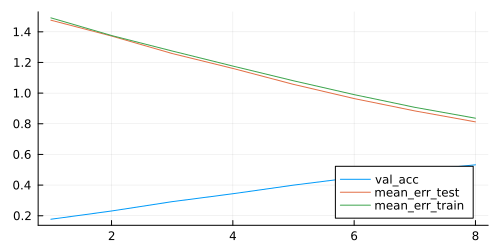

In [11]:
x = range(1, nr_of_epoch, step=1)

p= Plots.plot(x,val_acc,label="val_acc",legend=:bottomright, size=(500, 250))
p= Plots.plot!(p,x,mean_err_test,label="mean_err_test")
p= Plots.plot!(p,x,mean_err_train,label="mean_err_train")

## Summary

Now that we have more practice in designing deep networks, the step from a single to multiple layers of deep networks does not pose such a significant challenge any longer. In particular, we can reuse the training algorithm and data loader. Note, though, that implementing MLPs from scratch is nonetheless messy: naming and keeping track of the model parameters makes it difficult to extend models. For instance, imagine wanting to insert another layer between layers 42 and 43. This might now be layer 42b, unless we are willing to perform sequential renaming. Moreover, if we implement the network from scratch, it is much more difficult for the framework to perform meaningful performance optimizations.

Nonetheless, you have now reached the state of the art of the late 1980s when fully connected deep networks were the method of choice for neural network modeling. Our next conceptual step will be to consider images. Before we do so, we need to review a number of statistical basics and details on how to compute models efficiently.


## Exercises

1. Change the number of hidden units `num_hiddens` and plot how its number affects the accuracy of the model. What is the best value of this hyperparameter?
1. Try adding a hidden layer to see how it affects the results.
1. Why is it a bad idea to insert a hidden layer with a single neuron? What could go wrong?
1. How does changing the learning rate alter your results? With all other parameters fixed, which learning rate gives you the best results? How does this relate to the number of epochs?
1. Let's optimize over all hyperparameters jointly, i.e., learning rate, number of epochs, number of hidden layers, and number of hidden units per layer.
    1. What is the best result you can get by optimizing over all of them?
    1. Why it is much more challenging to deal with multiple hyperparameters?
    1. Describe an efficient strategy for optimizing over multiple parameters jointly.
1. Compare the speed of the framework and the from-scratch implementation for a challenging problem. How does it change with the complexity of the network?
1. Measure the speed of tensor-matrix multiplications for well-aligned and misaligned matrices. For instance, test for matrices with dimension 1024, 1025, 1026, 1028, and 1032.
    1. How does this change between GPUs and CPUs?
    1. Determine the memory bus width of your CPU and GPU.
1. Try out different activation functions. Which one works best?
1. Is there a difference between weight initializations of the network? Does it matter?
